In [119]:
import math
import random
from PIL import Image
from fastcore.all import concat
import torch
from transformers import logging
from pathlib import Path
from huggingface_hub import notebook_login
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt
import warnings
from typing import List
from textwrap import wrap

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler
from tqdm.auto import tqdm

# Not a best practice but adding ignoring warnings to remove constant macOS warnings about MPS
warnings.filterwarnings("ignore")
# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

torch.manual_seed(1)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu"

This is the standard Hugging Face diffusers Stabler Diffusion pipeline implementation:

In [4]:
hf_pipe = StableDiffusionPipeline.from_pretrained("stable-diffusion-v1-4").to(device)

In [5]:
hf_pipe.enable_attention_slicing()
hf_pipe.safety_checker = lambda images, **kwargs: (images, False)

In [6]:
prompt = "a photograph of an astronaut riding a horse"

  0%|          | 0/51 [00:00<?, ?it/s]

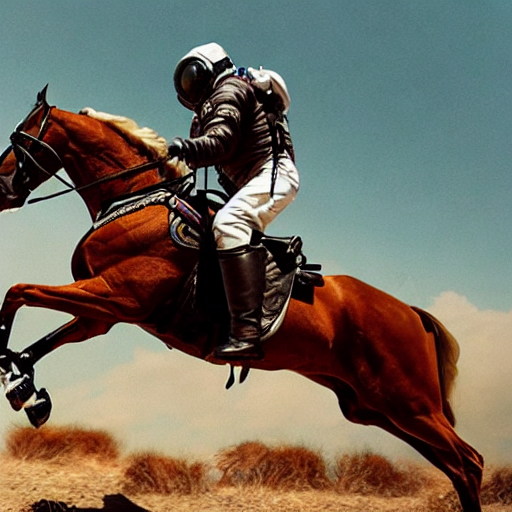

In [8]:
torch.manual_seed(1024)
hf_pipe(prompt).images[0]

Now let's do the same as the above but with our own tokenizer, VAE, and UNet:

In [7]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to(device)

In [8]:
# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to(device)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to(device)

# Attention slicing - improves performance on macOS
if torch.has_mps:
    slice_size = unet.config.attention_head_dim // 2
    unet.set_attention_slice(slice_size)

In [9]:
beta_start, beta_end = 0.00085, 0.012
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [100]:
# Utility functions
def text_embeddings(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to(device))[0].half()

def image_from_latents(latents):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        data = vae.decode(latents).sample[0]

    # Create PIL image
    data = (data / 2 + 0.5).clamp(0, 1)
    data = data.detach().cpu().permute(1, 2, 0).numpy()
    data = (data * 255).round().astype("uint8")
    image = Image.fromarray(data)
    return image
    
def show_image(image, seed, scale=0.5):
    print(f'Seed: {seed}')
    img = image.resize(((int)(image.width * scale), (int)(image.height * scale)))
    display(img)
    return img

# Display an array of images in a nice grid, or single row
def image_grid(images, rows = 1, width=256, height=256, title=None):
    count = len(images)
    cols = int(count / rows)
    if cols * rows < count:
        rows += 1
    # Calculate fig size based on individual image sizes    
    px = 1/plt.rcParams['figure.dpi']
    w = cols * width * px
    # Add some extra space for the caption/title since that can wrap
    h = (rows * height * px) + (rows * 30 * px)
    fig, axes = plt.subplots(rows, cols, figsize=(w, h))
    for y in range(rows):
        for x in range(cols):
            index = y*cols + x
            ref = axes[x] if rows == 1 else axes[y] if cols == 1 else axes[y, x]
            ref.axis('off')
            if index > count - 1:
                continue
            img = images[index]
            txt = f'Frame: {index}'
            if title is not None:
                if isinstance(title, str):
                    txt = f'{title}: {index}'
                elif isinstance(title, List):
                    txt = title[index]
            # Wrap title if it's really long
            txt = '\n'.join(wrap(txt, width=20))
            ref.title.set_text(txt)
            ref.imshow(img)
            ref.axis('off')

In [103]:
def generate(prompt, width=512, height=512, guidance=7.5, seed=None, steps=50):
    # Do we have a seed?
    if seed is None:
        seed = random.randrange(2 ** 32 - 1)
    generator = torch.manual_seed(seed)
    
    text = text_embeddings(prompt)
    uncond = text_embeddings('')
    emb = torch.cat([uncond, text])
    if seed: 
        torch.manual_seed(seed)

    latents = torch.randn((1, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to(device).half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): 
            tf = ts
            if torch.has_mps:
                tf = ts.type(torch.float32)
            u,t = unet(inp, tf, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + guidance * (t - u)
        latents = scheduler.step(pred, ts, latents).prev_sample
    image = image_from_latents(latents)
    return image, seed

  0%|          | 0/50 [00:00<?, ?it/s]

Seed: 894630702


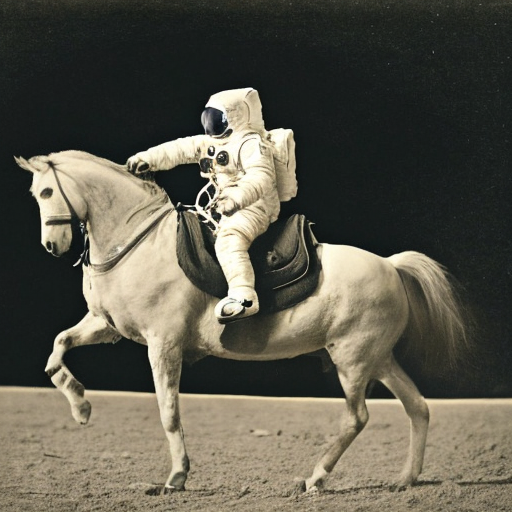

In [104]:
prompt = "a photograph of an astronaut riding a horse"
img_orig, seed = generate(prompt)
_ = show_image(img_orig, seed, scale=1)
# Good seeds - 894630702

Now let's try modifying `generate` to use guidance at 7.5 but re-scale the prediction as per method #1.b in [this post](https://forums.fast.ai/t/lesson-10-official-topic/101171/101?u=fahim):

```
pred = u + g * (t-u)
pred = pred * torch.norm(u)/torch.norm(pred)
```

In [113]:
def generate(prompt, width=512, height=512, guidance=7.5, seed=None, steps=50):
    # Do we have a seed?
    if seed is None:
        seed = random.randrange(2 ** 32 - 1)
    generator = torch.manual_seed(seed)
    
    text = text_embeddings(prompt)
    uncond = text_embeddings('')
    emb = torch.cat([uncond, text])
    if seed: 
        torch.manual_seed(seed)

    latents = torch.randn((1, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to(device).half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): 
            tf = ts
            if torch.has_mps:
                tf = ts.type(torch.float32)
            u,t = unet(inp, tf, encoder_hidden_states=emb).sample.chunk(2)
        # Original    
#         pred = u + guidance * (t - u)
        # New method 1 - guidance at 7.5 and the whole prediction re-scaled
        pred = u + guidance * (t - u)
        pred = pred * torch.norm(u)/torch.norm(pred)
        
        latents = scheduler.step(pred, ts, latents).prev_sample
    image = image_from_latents(latents)
    return image, seed    

Also, let's create a test harness so that the same code can be run over and over with the prompt, resulting image, and any other important data is automatically saved instead of manually editing every cell to give new variable names ...

In [114]:
images = [img_orig]
titles = ['Original']
def harness(prompt, seed=None, title=''):
    image, seed = generate(prompt, seed = seed)
    images.append(image)
    titles.append(title)
    show_image(image, seed, scale=1)
    return seed

# Method to remove the last image and title when there's an error
def pop(index = -1):
    images.pop(index)
    titles.pop(index)

  0%|          | 0/50 [00:00<?, ?it/s]

Seed: 894630702


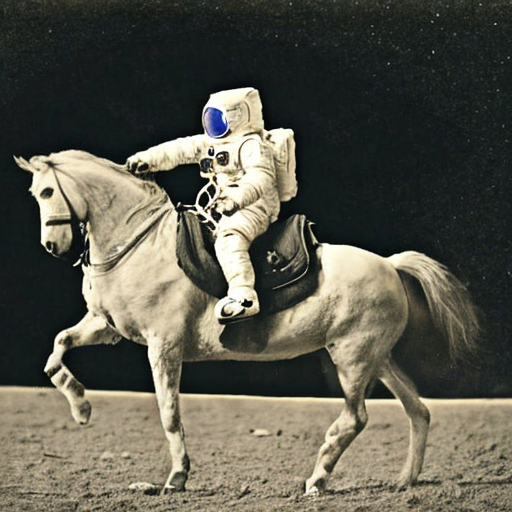

894630702

In [115]:
harness(prompt, seed=seed, title='7.5 Rescaled')

Let's compare those images side-by-side ...

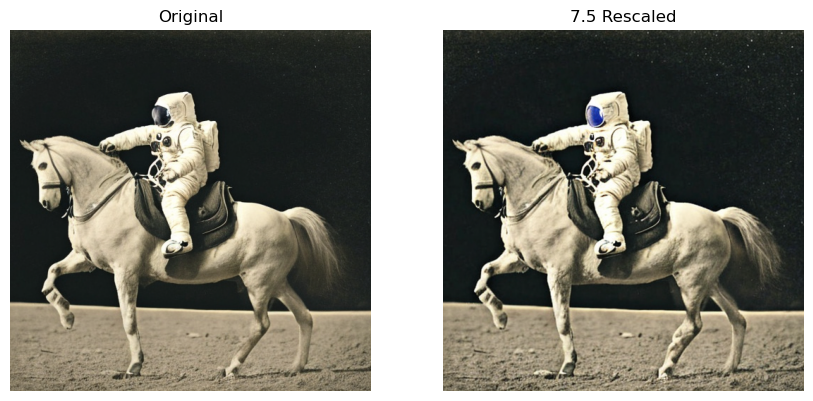

In [120]:
image_grid(images, title=titles, width=512, height=512)

Now let's set guidance to be in the 0 to 1 range with a default of 0.15, and re-scale the prediction as per method #2.a:

```
pred = u + g * (t-u) / torch.norm(t-u) * torch.norm(u)
```

In [121]:
def generate(prompt, width=512, height=512, guidance=0.15, seed=None, steps=50):
    # Do we have a seed?
    if seed is None:
        seed = random.randrange(2 ** 32 - 1)
    generator = torch.manual_seed(seed)
    
    text = text_embeddings(prompt)
    uncond = text_embeddings('')
    emb = torch.cat([uncond, text])
    if seed: 
        torch.manual_seed(seed)

    latents = torch.randn((1, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to(device).half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): 
            tf = ts
            if torch.has_mps:
                tf = ts.type(torch.float32)
            u,t = unet(inp, tf, encoder_hidden_states=emb).sample.chunk(2)
        # Original    
#         pred = u + guidance * (t - u)
        # New method 1 - guidance at 7.5 and the whole prediction re-scaled
#         pred = u + guidance * (t - u)
#         pred = pred * torch.norm(u)/torch.norm(pred)
        # New method 2 - guidance at 0.15 and rescaled prediction
        pred = u + guidance * (t - u) / torch.norm(t-u) * torch.norm(u)
        
        latents = scheduler.step(pred, ts, latents).prev_sample
    image = image_from_latents(latents)
    return image, seed

  0%|          | 0/50 [00:00<?, ?it/s]

Seed: 894630702


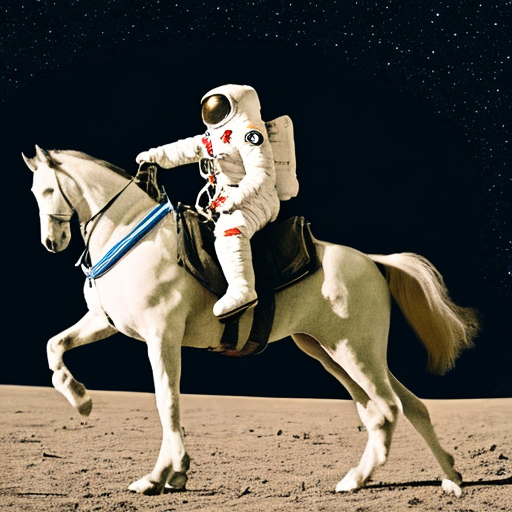

894630702

In [122]:
harness(prompt, seed=seed, title='0.15 Rescaled')

Guidance at 0 to 1 range and whole re-scaling as per method #2.b:

```
pred_nonscaled = u + g * (t-u) / torch.norm(t-u) * torch.norm(u)
pred = pred_nonscaled * torch.norm(u) / torch.norm(pred_nonscaled)
```

In [123]:
def generate(prompt, width=512, height=512, guidance=0.15, seed=None, steps=50):
    # Do we have a seed?
    if seed is None:
        seed = random.randrange(2 ** 32 - 1)
    generator = torch.manual_seed(seed)
    
    text = text_embeddings(prompt)
    uncond = text_embeddings('')
    emb = torch.cat([uncond, text])
    if seed: 
        torch.manual_seed(seed)

    latents = torch.randn((1, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to(device).half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): 
            tf = ts
            if torch.has_mps:
                tf = ts.type(torch.float32)
            u,t = unet(inp, tf, encoder_hidden_states=emb).sample.chunk(2)
        # Original    
#         pred = u + guidance * (t - u)
        # New method 1 - guidance at 7.5 and the whole prediction re-scaled
#         pred = u + guidance * (t - u)
#         pred = pred * torch.norm(u)/torch.norm(pred)
        # New method 2 - guidance at 0.15 and rescaled prediction
#         pred = u + guidance * (t - u) / torch.norm(t-u) * torch.norm(u)
        # New method 3 - guidance t 0.15 whole rescaling
        pred_nonscaled = u + guidance * (t - u) / torch.norm(t - u) * torch.norm(u)
        pred = pred_nonscaled * torch.norm(u) / torch.norm(pred_nonscaled)
        
        latents = scheduler.step(pred, ts, latents).prev_sample
    image = image_from_latents(latents)
    return image, seed

  0%|          | 0/50 [00:00<?, ?it/s]

Seed: 894630702


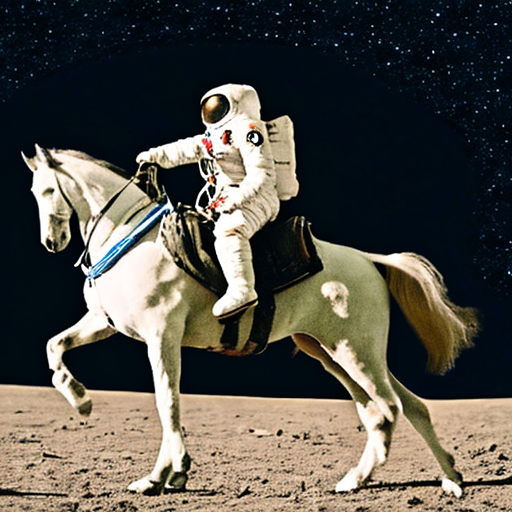

894630702

In [124]:
harness(prompt, seed=seed, title='0.15 Whole Rescaled')

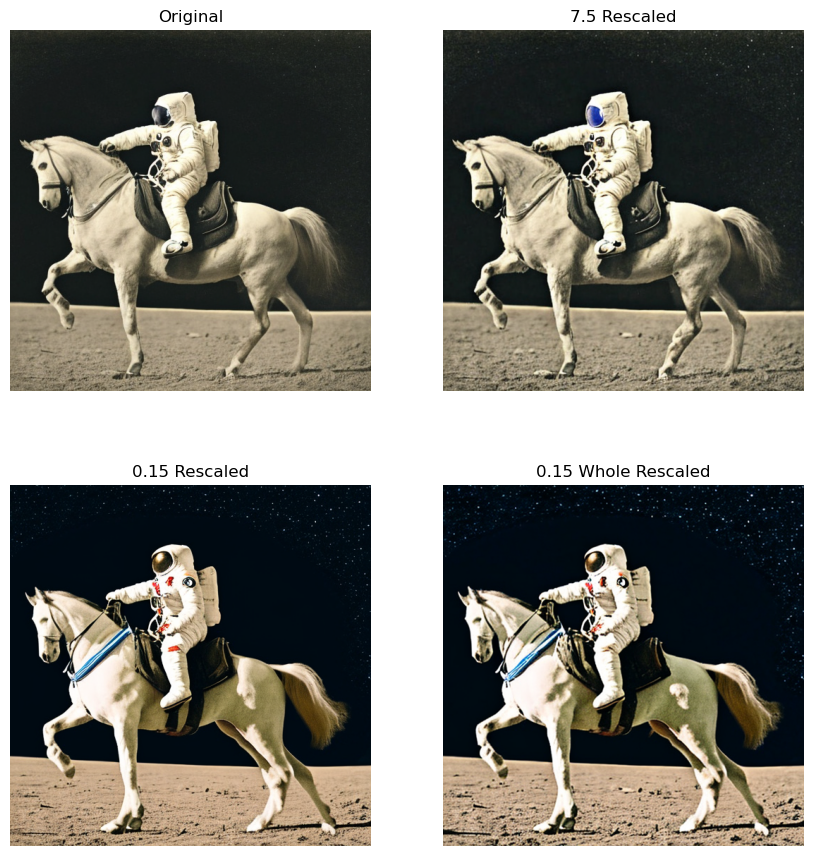

In [125]:
image_grid(images, title=titles, rows=2, width=512, height=512)

Now let's add the cosine scheduler to the mix ... no guidance value passed to the `generate` method at all but the cosine scheduler value range starts at 7.5 for guidance as per [this post](https://forums.fast.ai/t/lesson-10-official-topic/101171/112?u=fahim):

In [126]:
from timm.scheduler.cosine_lr import CosineLRScheduler
from timm.optim import create_optimizer
from timm import create_model
from types import SimpleNamespace

def get_lr_per_epoch(scheduler, num_epoch):
    lr_per_epoch = []
    for epoch in range(num_epoch):
        lr_per_epoch.append(scheduler.get_epoch_values(epoch))
    return lr_per_epoch

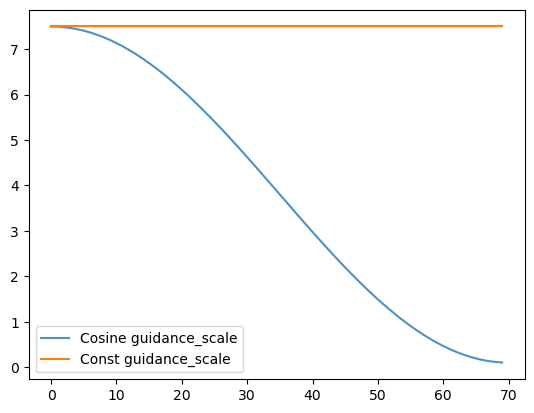

In [127]:
model = create_model('resnet18')
args = SimpleNamespace()
args.weight_decay = 0
args.lr = 7.5
args.opt = 'adam' 
args.momentum = 1.0
optimizer = create_optimizer(args, model)

num_epoch = 70
sched = CosineLRScheduler(optimizer, t_initial=num_epoch,lr_min=0.1)
lr_per_epoch = get_lr_per_epoch(sched, num_epoch)
plt.plot([i for i in range(num_epoch)], lr_per_epoch, label="Cosine guidance_scale", alpha=0.8);
plt.plot([i for i in range(num_epoch)],[7.5]*num_epoch,label="Const guidance_scale")

plt.legend()

In [146]:
def generate(prompt, width=512, height=512, seed=None, steps=50):
    # Do we have a seed?
    if seed is None:
        seed = random.randrange(2 ** 32 - 1)
    generator = torch.manual_seed(seed)
    
    text = text_embeddings(prompt)
    uncond = text_embeddings('')
    emb = torch.cat([uncond, text])
    if seed: 
        torch.manual_seed(seed)

    latents = torch.randn((1, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to(device).half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): 
            tf = ts
            if torch.has_mps:
                tf = ts.type(torch.float32)
            u,t = unet(inp, tf, encoder_hidden_states=emb).sample.chunk(2)
        # Original    
#         pred = u + guidance * (t - u)
        # New method 1 - guidance at 7.5 and the whole prediction re-scaled
#         pred = u + guidance * (t - u)
#         pred = pred * torch.norm(u)/torch.norm(pred)
        # New method 2 - guidance at 0.15 and rescaled prediction
#         pred = u + guidance * (t - u) / torch.norm(t-u) * torch.norm(u)
        # New method 3 - guidance t 0.15 whole rescaling
#         pred_nonscaled = u + guidance * (t - u) / torch.norm(t - u) * torch.norm(u)
#         pred = pred_nonscaled * torch.norm(u) / torch.norm(pred_nonscaled)
        # Cosine scheduler
        gs = lr_per_epoch[i][0]
        pred = u + gs*(t-u)
        
        latents = scheduler.step(pred, ts, latents).prev_sample
    image = image_from_latents(latents)
    return image, seed

  0%|          | 0/50 [00:00<?, ?it/s]

Seed: 894630702


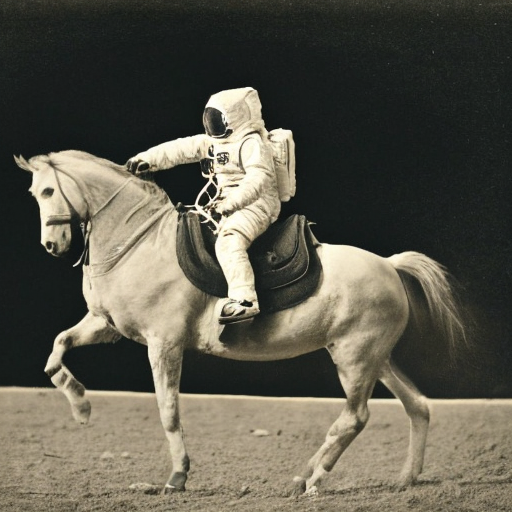

894630702

In [147]:
harness(prompt, seed=seed, title='Cosine Scheduler')

Combined cosine scheduler and previous scaling method as per [this post](https://forums.fast.ai/t/lesson-10-official-topic/101171/119?u=fahim):

```
cos_schedule = 0.5 * (1 + torch.cos(torch.linspace(0, math.pi, num_inference_steps)))
cos_schedule = guidance_scale * cos_schedule
...
noise_pred_nonscaled = u + cos_schedule[i] * (t - u)/torch.norm(t - u) * torch.norm(u)
noise_pred = noise_pred_nonscaled * torch.norm(u)/torch.norm(noise_pred_nonscaled)
```

In [153]:
def generate(prompt, width=512, height=512, guidance=7.5, seed=None, steps=50):
    # Do we have a seed?
    if seed is None:
        seed = random.randrange(2 ** 32 - 1)
    generator = torch.manual_seed(seed)
    
    text = text_embeddings(prompt)
    uncond = text_embeddings('')
    emb = torch.cat([uncond, text])
    if seed: 
        torch.manual_seed(seed)

    latents = torch.randn((1, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to(device).half() * scheduler.init_noise_sigma
    
    # Combined method - calculate cosine schedule outside the loop
    cos_schedule = 0.5 * (1 + torch.cos(torch.linspace(0, math.pi, steps)))
    cos_schedule = guidance * cos_schedule

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): 
            tf = ts
            if torch.has_mps:
                tf = ts.type(torch.float32)
            u,t = unet(inp, tf, encoder_hidden_states=emb).sample.chunk(2)
        # Original    
#         pred = u + guidance * (t - u)
        # New method 1 - guidance at 7.5 and the whole prediction re-scaled
#         pred = u + guidance * (t - u)
#         pred = pred * torch.norm(u)/torch.norm(pred)
        # New method 2 - guidance at 0.15 and rescaled prediction
#         pred = u + guidance * (t - u) / torch.norm(t-u) * torch.norm(u)
        # New method 3 - guidance t 0.15 whole rescaling
#         pred_nonscaled = u + guidance * (t - u) / torch.norm(t - u) * torch.norm(u)
#         pred = pred_nonscaled * torch.norm(u) / torch.norm(pred_nonscaled)
        # Cosine scheduler
#         gs = lr_per_epoch[i][0]
#         pred = u + gs*(t-u)
        # Combined method - cosine schedule is calculated outside the loop (see above)
        # The commented out line (matching the original code) gives me noise, so switching to a variation
        # which does work for me - not enough time to investigate right now ...
#         noise_pred_nonscaled = u + cos_schedule[i] * (t - u) / torch.norm(t - u) * torch.norm(u)
        noise_pred_nonscaled = u + cos_schedule[i] * (t - u) 
        pred = noise_pred_nonscaled * torch.norm(u) / torch.norm(noise_pred_nonscaled)
        
        latents = scheduler.step(pred, ts, latents).prev_sample
    image = image_from_latents(latents)
    return image, seed

  0%|          | 0/50 [00:00<?, ?it/s]

Seed: 894630702


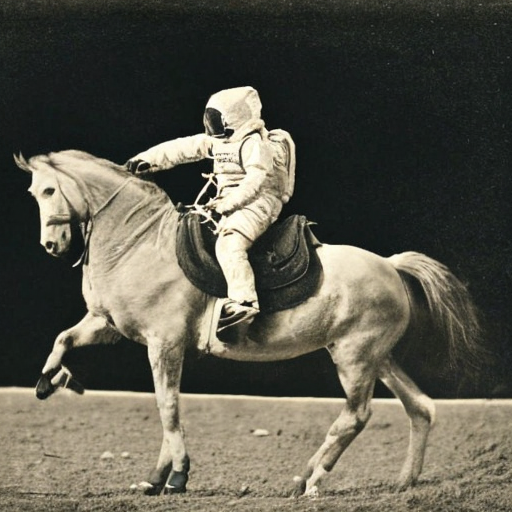

894630702

In [154]:
harness(prompt, seed=seed, title='Combined')

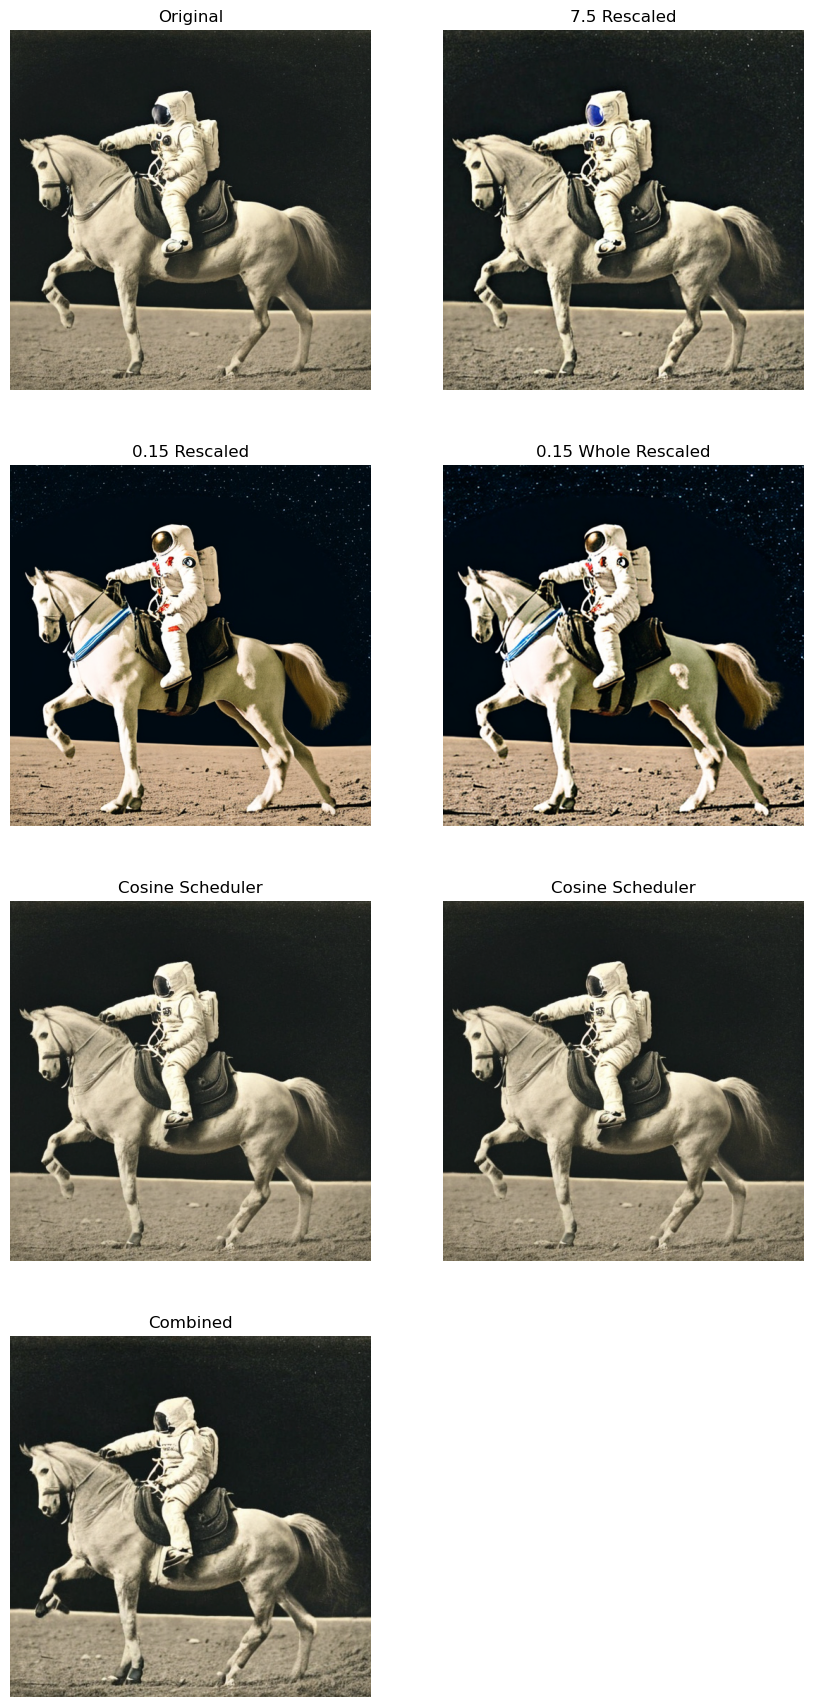

In [155]:
image_grid(images, title=titles, rows=3, width=512, height=512)

**Other things to try**
* Linear decay as per [this post](https://forums.fast.ai/t/lesson-10-official-topic/101171/112?u=fahim)